In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import cobra
import snek

In [2]:
d4p3 = cobra.io.read_sbml_model("../models/ecoli_core_btdl_pathway.xml")

In [3]:
xls = pd.ExcelFile("../models/240214_Data_Figure3C.xlsx")
rep1 = pd.read_excel(xls, 'Figure 3C')
rep2 = pd.read_excel(xls, 'Figure S3')
reps = [rep1,rep2]

## Fit Stage 1

In [4]:
st1rep1 = np.arange(1, 9)
st1rep2 = np.arange(2,10)
tmpV = np.append(rep1.loc[st1rep1,"V reactor [ml]"].values,rep2.loc[st1rep2,"V reactor [ml]"].values)/1000
st1tmpt1 = rep1.loc[st1rep1,"time [h]"].values
st1tmpt2 = rep2.loc[st1rep2,"time [h]"].values
st1 = {
    "rep": ["rep1"]*len(st1rep1) + ["rep2"]*len(st1rep2),
    "color": ["blue"]*len(st1rep1) + ["lightblue"]*len(st1rep2),
    "t": np.append(st1tmpt1-st1tmpt1[0],st1tmpt2-st1tmpt2[0]),
    "V": tmpV,
    "X": np.append(rep1.loc[st1rep1,"CDM [g/l]"].values,rep2.loc[st1rep2,"CDM [g/l]"].values)*tmpV,
    "G": np.append(rep1.loc[st1rep1,"glucose [g/l]"].values,rep2.loc[st1rep2,"glucose [g/l]"].values)*tmpV,
    "B": np.append(rep1.loc[st1rep1,"meso-2,3-BDO [g/l]"].values,rep2.loc[st1rep2,"meso-2,3-BDO [g/l]"].values)*tmpV,
    "A": np.append(rep1.loc[st1rep1,"acetoin [g/l]"].values,rep2.loc[st1rep2,"acetoin [g/l]"].values)*tmpV,
}
st1 = pd.DataFrame(st1)

# CONVERT EVERYTHING TO MMOL
st1.G = st1.G.values/d4p3.metabolites.glc__D_e.formula_weight*1000
st1.B = st1.B.values/d4p3.metabolites.bt23dl_c.formula_weight*1000
st1.A = st1.A.values/d4p3.metabolites.acoin_c.formula_weight*1000
st1.insert(8,"D",st1.B+st1.A) # D stands for diols, so acetoin and butanediol

In [5]:
def growth(x0,mu,t):
    x = x0*np.exp(mu*t)
    return x

def rate(p0,pi,x0,mu,t):
    p = p0+pi*x0/mu*(np.exp(mu*t)-1)
    return p

def fun_to_min_s1(theta,return_simulations=False):
    x01,g01,d01,a01,x02,g02,d02,a02,mu,qG,qD,qA = theta
    
    
    tmp_t = st1.t.values
    tmp_X = st1.X.values
    tmp_G = st1.G.values
    tmp_B = st1.B.values
    tmp_D = st1.D.values
    tmp_A = st1.A.values
    nonan_X = np.invert(np.isnan(tmp_X))
    is_one = st1.rep == "rep1"
    is_two = np.invert(is_one)
    # print(tmp_t[is_one & nonan_X],tmp_X)
    
    s_X1 = growth(x01,mu,tmp_t[is_one & nonan_X])
    s_X2 = growth(x02,mu,tmp_t[is_two & nonan_X])
    s_G1 = rate(g01,qG,x01,mu,tmp_t[is_one])
    s_G2 = rate(g02,qG,x02,mu,tmp_t[is_two])
    s_D1 = rate(d01,qD,x01,mu,tmp_t[is_one])
    s_D2 = rate(d02,qD,x02,mu,tmp_t[is_two])
    s_A1 = rate(a01,qA,x01,mu,tmp_t[is_one])
    s_A2 = rate(a02,qA,x02,mu,tmp_t[is_two])
    
    # print(s_X1,s_G1,s_D1,s_A1)
    # adfjkadkf
    
    loss_cdw1  = np.sum(((s_X1-tmp_X[is_one & nonan_X])/np.max(tmp_X[is_one & nonan_X]))**2)
    loss_cdw2  = np.sum(((s_X2-tmp_X[is_two & nonan_X])/np.max(tmp_X[is_two & nonan_X]))**2)
    loss_cdw = loss_cdw1 + loss_cdw2
    
    loss_glu1  = np.sum(((s_G1-tmp_G[is_one])/np.max(tmp_G[is_one]))**2)
    loss_glu2  = np.sum(((s_G2-tmp_G[is_two])/np.max(tmp_G[is_two]))**2)
    loss_glu = loss_glu1 + loss_glu2
    
    loss_diol1 = np.sum(((s_D1-tmp_D[is_one])/np.max(tmp_D[is_one]))**2)
    loss_diol2 = np.sum(((s_D2-tmp_D[is_two])/np.max(tmp_D[is_two]))**2)
    loss_diol = loss_diol1 + loss_diol2
    
    loss_acoin1 = np.sum(((s_A1-tmp_A[is_one])/np.max(tmp_A[is_one]))**2)
    loss_acoin2 = np.sum(((s_A2-tmp_A[is_two])/np.max(tmp_A[is_two]))**2)
    loss_acoin = loss_acoin1 + loss_acoin2
    
    loss = loss_cdw + loss_glu + loss_diol + loss_acoin
    
    global n
    if n%100 == 0:
        print("{:5} {:6.2f} {:6.2f} {:6.2F} {:6.2f} {:6.2f}".format(n,loss,loss_cdw,loss_glu,loss_diol,loss_acoin))
    n += 1
    if return_simulations:
        tmp_t = np.linspace(np.min(tmp_t),np.max(tmp_t),100)
        s_X1 = growth(x01,mu,tmp_t)
        s_X2 = growth(x02,mu,tmp_t)
        s_G1 = rate(g01,qG,x01,mu,tmp_t)
        s_G2 = rate(g02,qG,x02,mu,tmp_t)
        s_D1 = rate(d01,qD,x01,mu,tmp_t)
        s_D2 = rate(d02,qD,x02,mu,tmp_t)
        s_A1 = rate(a01,qA,x01,mu,tmp_t)
        s_A2 = rate(a02,qA,x02,mu,tmp_t)
        return loss, tmp_t, s_X1, s_X2, s_G1, s_G2, s_D1, s_D2, s_A1, s_A2
    else:
        return loss

In [6]:
n = 0
# x01,g01,d01,a01,x02,g02,d02,a02,mu,qG,qD,qA
theta0 = [1,50,.5,.0,
          1,50,.5,.0,
          .1,-.1,.01,.001]
theta0 = np.array([ 3.30687998e-01,  2.76727611e+02,  1.29034790e+00, -4.87213872e+00,
        2.14720681e-01,  2.63132928e+02,  7.99573822e+00, -1.51581353e+00,
        1.89444874e-01, -6.74732043e+00,  3.26340343e+00,  1.88328783e+00])
sol = minimize(fun = fun_to_min_s1,
        x0  = theta0,
        method = 'Nelder-Mead',
        options = {"xatol":1e-10,"fatol":1e-10,"maxfev":1e5}
        )
x01,g01,d01,a01,x02,g02,d02,a02,mu,qG,qD,qA = sol.x
loss, tmp_t, s_X1, s_X2, s_G1, s_G2, s_D1, s_D2, s_A1, s_A2 = fun_to_min_s1(sol.x,True)
print()
print(sol.message)
print(f"FINAL LOSS = {loss:7.4f}")
print()
print(f"X1(t) = {x01:7.4f} * exp({mu:.4f}*t)")
print(f"X2(t) = {x02:7.4f} * exp({mu:.4f}*t)")
print(f"G1(t) = {g01:7.4f} * {qG:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"G2(t) = {g02:7.4f} * {qG:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"D1(t) = {d01:7.4f} * {qD:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"D2(t) = {d02:7.4f} * {qD:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"A1(t) = {a01:7.4f} * {qA:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"A2(t) = {a02:7.4f} * {qA:+.4f}*X0/mu*(exp(mu t)-1)")

    0   0.11   0.04   0.01   0.01   0.04
  100   0.11   0.04   0.01   0.01   0.04
  200   0.11   0.04   0.01   0.01   0.04
  300   0.11   0.04   0.01   0.01   0.04
  400   0.11   0.04   0.01   0.01   0.04
  500   0.11   0.04   0.01   0.01   0.04
  600   0.11   0.04   0.01   0.01   0.04
  700   0.11   0.04   0.01   0.01   0.04
  800   0.11   0.04   0.01   0.01   0.04
  900   0.11   0.04   0.01   0.01   0.04
 1000   0.11   0.04   0.01   0.01   0.04

Optimization terminated successfully.
FINAL LOSS =  0.1077

X1(t) =  0.3307 * exp(0.1894*t)
X2(t) =  0.2147 * exp(0.1894*t)
G1(t) = 276.7276 * -6.7473*X0/mu*(exp(mu t)-1)
G2(t) = 263.1329 * -6.7473*X0/mu*(exp(mu t)-1)
D1(t) =  1.2903 * +3.2634*X0/mu*(exp(mu t)-1)
D2(t) =  7.9957 * +3.2634*X0/mu*(exp(mu t)-1)
A1(t) = -4.8721 * +1.8833*X0/mu*(exp(mu t)-1)
A2(t) = -1.5158 * +1.8833*X0/mu*(exp(mu t)-1)


## Fit Stage 2b

In [7]:
st2rep1 = np.arange(10, 23)
st2rep2 = np.arange(11,23)
tmpV = np.append(rep1.loc[st2rep1,"V reactor [ml]"].values,rep2.loc[st2rep2,"V reactor [ml]"].values)/1000
st2tmpt1 = rep1.loc[st2rep1,"time [h]"].values
st2tmpt2 = rep2.loc[st2rep2,"time [h]"].values

tmpGrep1 = rep1.loc[st2rep1,"glucose [g/l]"].values * tmpV[:len(st2rep1)]
old = 0
adder = np.zeros(len(tmpGrep1))
for i in range(len(tmpGrep1)):
    new = tmpGrep1[::-1][i]
    if new >= old:
        old = new
    else:
        adder[:-i] += old-new
        # print(old-new)
        old = new
Gfedrep1 = adder+tmpGrep1

tmpGrep2 = rep1.loc[st2rep2,"glucose [g/l]"].values * tmpV[len(st2rep1):]
old = 0
adder = np.zeros(len(tmpGrep2))
for i in range(len(tmpGrep2)):
    new = tmpGrep2[::-1][i]
    if new >= old:
        old = new
    else:
        adder[:-i] += old-new
        # print(old-new)
        old = new
Gfedrep2 = adder+tmpGrep2

st2 = {
    "rep": ["rep1"]*len(st2rep1) + ["rep2"]*len(st2rep2),
    "color": ["blue"]*len(st2rep1) + ["lightblue"]*len(st2rep2),
    "t": np.append(st2tmpt1-st1tmpt1[0],st2tmpt2-st1tmpt2[0]),
    "V": tmpV,
    "X": np.append(rep1.loc[st2rep1,"CDM [g/l]"].values,rep2.loc[st2rep2,"CDM [g/l]"].values) * tmpV,
    "G": np.append(Gfedrep1,Gfedrep2),
    "B": np.append(rep1.loc[st2rep1,"meso-2,3-BDO [g/l]"].values,rep2.loc[st2rep2,"meso-2,3-BDO [g/l]"].values) * tmpV,
    "A": np.append(rep1.loc[st2rep1,"acetoin [g/l]"].values,rep2.loc[st2rep2,"acetoin [g/l]"].values)*tmpV,
}

st2b = pd.DataFrame(st2)

st2b.G = st2b.G.values/d4p3.metabolites.glc__D_e.formula_weight*1000
st2b.B = st2b.B.values/d4p3.metabolites.bt23dl_c.formula_weight*1000
st2b.A = st2b.A.values/d4p3.metabolites.acoin_c.formula_weight*1000
st2b.insert(8,"D",st2b.B+st2b.A) # D stands for diols, so acetoin and butanediol

,rep,color,t,V,X,G,B,A,D
0,rep1,blue,19.977778,0.91230,NaN,760.394462,190.979466,0.000000,190.979466
1,rep1,blue,24.990556,0.89300,7.895608,693.432633,235.237689,0.000000,235.237689
2,rep1,blue,28.037500,0.88110,NaN,626.034133,282.315017,0.000000,282.315017
3,rep1,blue,31.013333,0.87450,NaN,577.651266,293.276197,0.000000,293.276197
4,rep1,blue,31.049167,0.92150,8.278142,577.651266,304.190223,0.000000,304.190223
5,rep1,blue,32.014167,0.90430,NaN,551.670858,304.300730,0.000000,304.300730
6,rep1,blue,36.011389,0.89920,NaN,482.998557,339.473805,0.000000,339.473805
7,rep1,blue,39.993333,0.89630,7.670834,425.127479,391.986421,0.000000,391.986421
8,rep1,blue,44.266667,0.87970,NaN,349.405980,431.835926,0.000000,431.835926
9,rep1,blue,48.173889,0.86970,NaN,290.694330,465.513017,0.000000,465.513017


In [8]:
def growth(x0,mu,t):
    x = x0*np.exp(mu*t)
    return x

def rate(p0,pi,x0,mu,t):
    p = p0+pi*x0/mu*(np.exp(mu*t)-1)
    return p

def fun_to_min_s2b(theta,return_simulations=False):
    x01,g01,d01,a01,x02,g02,d02,a02,mu,qG,qD,qA = theta
    
    
    tmp_t = st2b.t.values
    tmp_X = st2b.X.values
    tmp_G = st2b.G.values
    tmp_D = st2b.B.values # change here to btdl
    tmp_A = st2b.A.values
    nonan_X = np.invert(np.isnan(tmp_X))
    is_one = st2b.rep == "rep1"
    is_two = np.invert(is_one)
    # print(tmp_t[is_one & nonan_X],tmp_X)
    
    s_X1 = growth(x01,mu,tmp_t[is_one & nonan_X])
    s_X2 = growth(x02,mu,tmp_t[is_two & nonan_X])
    s_G1 = rate(g01,qG,x01,mu,tmp_t[is_one])
    s_G2 = rate(g02,qG,x02,mu,tmp_t[is_two])
    s_D1 = rate(d01,qD,x01,mu,tmp_t[is_one])
    s_D2 = rate(d02,qD,x02,mu,tmp_t[is_two])
    s_A1 = rate(a01,qA,x01,mu,tmp_t[is_one])
    s_A2 = rate(a02,qA,x02,mu,tmp_t[is_two])
    
    # print(s_X1,s_G1,s_D1,s_A1)
    loss_cdw1  = np.sum(((s_X1-tmp_X[is_one & nonan_X])/np.max(tmp_X[is_one & nonan_X]))**2)
    loss_cdw2  = np.sum(((s_X2-tmp_X[is_two & nonan_X])/np.max(tmp_X[is_two & nonan_X]))**2)
    loss_cdw = loss_cdw1 + loss_cdw2
    
    loss_glu1  = np.sum(((s_G1-tmp_G[is_one])/np.max(tmp_G[is_one]))**2)
    loss_glu2  = np.sum(((s_G2-tmp_G[is_two])/np.max(tmp_G[is_two]))**2)
    loss_glu = loss_glu1 + loss_glu2
    
    loss_diol1 = np.sum(((s_D1-tmp_D[is_one])/np.max(tmp_D[is_one]))**2)
    loss_diol2 = np.sum(((s_D2-tmp_D[is_two])/np.max(tmp_D[is_two]))**2)
    loss_diol = loss_diol1 + loss_diol2
    
    loss_acoin1 = np.sum(((s_A1-tmp_A[is_one])/np.max(tmp_A[is_one]))**2)
    loss_acoin2 = np.sum(((s_A2-tmp_A[is_two])/np.max(tmp_A[is_two]))**2)
    loss_acoin = loss_acoin1 + loss_acoin2
    
    loss = loss_cdw + loss_glu + loss_diol + loss_acoin
    
    global n
    if n%100 == 0:
        print("{:5} {:6.2f} {:6.2f} {:6.2F} {:6.2f} {:6.2f}".format(n,loss,loss_cdw,loss_glu,loss_diol,loss_acoin))
    n += 1
    if return_simulations:
        tmp_t = np.linspace(np.min(tmp_t),np.max(tmp_t),100)
        s_X1 = growth(x01,mu,tmp_t)
        s_X2 = growth(x02,mu,tmp_t)
        s_G1 = rate(g01,qG,x01,mu,tmp_t)
        s_G2 = rate(g02,qG,x02,mu,tmp_t)
        s_D1 = rate(d01,qD,x01,mu,tmp_t)
        s_D2 = rate(d02,qD,x02,mu,tmp_t)
        s_A1 = rate(a01,qA,x01,mu,tmp_t)
        s_A2 = rate(a02,qA,x02,mu,tmp_t)
        return loss, tmp_t, s_X1, s_X2, s_G1, s_G2, s_D1, s_D2, s_A1, s_A2
    else:
        return loss

In [9]:
n = 0
# x01,g01,x02,g02,mu,qG,qB
theta0 = [10,150,15,.0,
          10,150,15,.0,
          .01,-.1,.01,.001]
theta0 = np.array([ 6.76441115e+00,  9.87010357e+02, -1.47272496e+01, -3.08822182e-01,
        6.56353038e+00,  9.06658702e+02,  2.04377465e+01,  1.13976889e+01,
        4.91161874e-03, -1.81433574e+00,  1.34539305e+00,  1.25047578e-03])
sol = minimize(fun = fun_to_min_s2b,
        x0  = theta0,
        method = 'Nelder-Mead',
        options = {"xatol":1e-10,"fatol":1e-10,"maxfev":1e5}
        )
x01,g01,d01,a01,x02,g02,d02,a02,mu,qG,qD,qA = sol.x
loss, tmp_t, s_X1, s_X2, s_G1, s_G2, s_D1, s_D2, s_A1, s_A2 = fun_to_min_s2b(sol.x,True)
print()
print(sol.message)
print(f"FINAL LOSS = {loss:7.4f}")
print()
print(f"X1(t) = {x01:7.4f} * exp({mu:.4f}*t)")
print(f"X2(t) = {x02:7.4f} * exp({mu:.4f}*t)")
print(f"G1(t) = {g01:7.4f} * {qG:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"G2(t) = {g02:7.4f} * {qG:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"B1(t) = {d01:7.4f} * {qD:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"B2(t) = {d02:7.4f} * {qD:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"A1(t) = {a01:7.4f} * {qA:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"A2(t) = {a02:7.4f} * {qA:+.4f}*X0/mu*(exp(mu t)-1)")

    0   1.51   0.01   0.03   0.03   1.44
  100   1.51   0.01   0.03   0.03   1.44
  200   1.51   0.01   0.03   0.03   1.44
  300   1.51   0.01   0.03   0.03   1.44
  400   1.51   0.01   0.03   0.03   1.44
  500   1.51   0.01   0.03   0.03   1.44
  600   1.51   0.01   0.03   0.03   1.44
  700   1.51   0.01   0.03   0.03   1.44
  800   1.51   0.01   0.03   0.03   1.44
  900   1.51   0.01   0.03   0.03   1.44
 1000   1.51   0.01   0.03   0.03   1.44

Optimization terminated successfully.
FINAL LOSS =  1.5115

X1(t) =  6.7644 * exp(0.0049*t)
X2(t) =  6.5635 * exp(0.0049*t)
G1(t) = 987.0104 * -1.8143*X0/mu*(exp(mu t)-1)
G2(t) = 906.6587 * -1.8143*X0/mu*(exp(mu t)-1)
B1(t) = -14.7273 * +1.3454*X0/mu*(exp(mu t)-1)
B2(t) = 20.4377 * +1.3454*X0/mu*(exp(mu t)-1)
A1(t) = -0.3088 * +0.0013*X0/mu*(exp(mu t)-1)
A2(t) = 11.3977 * +0.0013*X0/mu*(exp(mu t)-1)


## Fit Stage 2a

In [10]:
st2rep1 = np.arange(9, 11)
st2rep2 = np.arange(10,12)
tmpV = np.append(rep1.loc[st2rep1,"V reactor [ml]"].values,rep2.loc[st2rep2,"V reactor [ml]"].values)/1000
st2tmpt1 = rep1.loc[st2rep1,"time [h]"].values
st2tmpt2 = rep2.loc[st2rep2,"time [h]"].values

tmpGrep1 = rep1.loc[st2rep1,"glucose [g/l]"].values * tmpV[:len(st2rep1)]
old = 0
adder = np.zeros(len(tmpGrep1))
for i in range(len(tmpGrep1)):
    new = tmpGrep1[::-1][i]
    if new >= old:
        old = new
    else:
        adder[:-i] += old-new
        # print(old-new)
        old = new
Gfedrep1 = adder+tmpGrep1

tmpGrep2 = rep1.loc[st2rep2,"glucose [g/l]"].values * tmpV[len(st2rep1):]
old = 0
adder = np.zeros(len(tmpGrep2))
for i in range(len(tmpGrep2)):
    new = tmpGrep2[::-1][i]
    if new >= old:
        old = new
    else:
        adder[:-i] += old-new
        # print(old-new)
        old = new
Gfedrep2 = adder+tmpGrep2

st2 = {
    "rep": ["rep1"]*len(st2rep1) + ["rep2"]*len(st2rep2),
    "color": ["blue"]*len(st2rep1) + ["lightblue"]*len(st2rep2),
    "t": np.append(st2tmpt1-st1tmpt1[0],st2tmpt2-st1tmpt2[0]),
    "V": tmpV,
    "X": np.append(rep1.loc[st2rep1,"CDM [g/l]"].values,rep2.loc[st2rep2,"CDM [g/l]"].values) * tmpV,
    "G": np.append(Gfedrep1,Gfedrep2),
    "B": np.append(rep1.loc[st2rep1,"meso-2,3-BDO [g/l]"].values,rep2.loc[st2rep2,"meso-2,3-BDO [g/l]"].values) * tmpV,
    "A": np.append(rep1.loc[st2rep1,"acetoin [g/l]"].values,rep2.loc[st2rep2,"acetoin [g/l]"].values)*tmpV,
}

st2a = pd.DataFrame(st2)

st2a.G = st2a.G.values/d4p3.metabolites.glc__D_e.formula_weight*1000
st2a.B = st2a.B.values/d4p3.metabolites.bt23dl_c.formula_weight*1000
st2a.A = st2a.A.values/d4p3.metabolites.acoin_c.formula_weight*1000
st2a.insert(8,"D",st2a.B+st2a.A) # D stands for diols, so acetoin and butanediol

,rep,color,t,V,X,G,B,A,D
0,rep1,blue,17.188611,0.8841,7.478013,264.595648,56.388129,71.667143,128.055271
1,rep1,blue,19.977778,0.9123,NaN,182.743196,190.979466,0.000000,190.979466
2,rep2,lightblue,18.759444,0.9033,7.271565,180.940402,68.351335,77.651604,146.002939
3,rep2,lightblue,19.943333,0.8895,NaN,115.327576,174.517054,0.000000,174.517054


In [11]:
def growth(x0,mu,t):
    x = x0*np.exp(mu*t)
    return x

def rate(p0,pi,x0,mu,t):
    p = p0+pi*x0/mu*(np.exp(mu*t)-1)
    return p

def fun_to_min_s2a(theta,return_simulations=False):
    x01,g01,d01,a01,x02,g02,d02,a02,mu,qG,qD,qA = theta
    
    
    tmp_t = st2a.t.values
    tmp_X = st2a.X.values
    tmp_G = st2a.G.values
    tmp_D = st2a.B.values # change here to btdl
    tmp_A = st2a.A.values
    nonan_X = np.invert(np.isnan(tmp_X))
    is_one = st2a.rep == "rep1"
    is_two = np.invert(is_one)
    # print(tmp_t[is_one & nonan_X],tmp_X)
    
    s_X1 = growth(x01,mu,tmp_t[is_one & nonan_X])
    s_X2 = growth(x02,mu,tmp_t[is_two & nonan_X])
    s_G1 = rate(g01,qG,x01,mu,tmp_t[is_one])
    s_G2 = rate(g02,qG,x02,mu,tmp_t[is_two])
    s_D1 = rate(d01,qD,x01,mu,tmp_t[is_one])
    s_D2 = rate(d02,qD,x02,mu,tmp_t[is_two])
    s_A1 = rate(a01,qA,x01,mu,tmp_t[is_one])
    s_A2 = rate(a02,qA,x02,mu,tmp_t[is_two])
    
    # print(s_X1,s_G1,s_D1,s_A1)
    loss_cdw1  = np.sum(((s_X1-tmp_X[is_one & nonan_X])/np.max(tmp_X[is_one & nonan_X]))**2)
    loss_cdw2  = np.sum(((s_X2-tmp_X[is_two & nonan_X])/np.max(tmp_X[is_two & nonan_X]))**2)
    loss_cdw = loss_cdw1 + loss_cdw2
    
    loss_glu1  = np.sum(((s_G1-tmp_G[is_one])/np.max(tmp_G[is_one]))**2)
    loss_glu2  = np.sum(((s_G2-tmp_G[is_two])/np.max(tmp_G[is_two]))**2)
    loss_glu = loss_glu1 + loss_glu2
    
    loss_diol1 = np.sum(((s_D1-tmp_D[is_one])/np.max(tmp_D[is_one]))**2)
    loss_diol2 = np.sum(((s_D2-tmp_D[is_two])/np.max(tmp_D[is_two]))**2)
    loss_diol = loss_diol1 + loss_diol2
    
    loss_acoin1 = np.sum(((s_A1-tmp_A[is_one])/np.max(tmp_A[is_one]))**2)
    loss_acoin2 = np.sum(((s_A2-tmp_A[is_two])/np.max(tmp_A[is_two]))**2)
    loss_acoin = loss_acoin1 + loss_acoin2
    
    loss = loss_cdw + loss_glu + loss_diol + loss_acoin
    
    global n
    if n%100 == 0:
        print("{:5} {:6.2f} {:6.2f} {:6.2F} {:6.2f} {:6.2f}".format(n,loss,loss_cdw,loss_glu,loss_diol,loss_acoin))
    n += 1
    if return_simulations:
        tmp_t = np.linspace(np.min(tmp_t),np.max(tmp_t),100)
        s_X1 = growth(x01,mu,tmp_t)
        s_X2 = growth(x02,mu,tmp_t)
        s_G1 = rate(g01,qG,x01,mu,tmp_t)
        s_G2 = rate(g02,qG,x02,mu,tmp_t)
        s_D1 = rate(d01,qD,x01,mu,tmp_t)
        s_D2 = rate(d02,qD,x02,mu,tmp_t)
        s_A1 = rate(a01,qA,x01,mu,tmp_t)
        s_A2 = rate(a02,qA,x02,mu,tmp_t)
        return loss, tmp_t, s_X1, s_X2, s_G1, s_G2, s_D1, s_D2, s_A1, s_A2
    else:
        return loss

In [12]:
n = 0
# x01,g01,x02,g02,mu,qG,qB
theta0 = [10,150,15,.0,
          10,150,15,.0,
          4.911e-03,-1.8143,.01,-.1]
theta0 = np.array([ 5.74599969e+00,  4.26568391e+02, -8.28757768e+02,  5.82160172e+02,
        7.56968281e+00,  4.26950893e+02, -1.18737880e+03,  7.89569344e+02,
        4.91100000e-03, -1.81430000e+00,  8.51662645e+00, -4.88519164e+00])
sol = minimize(fun = fun_to_min_s2a,
        x0  = theta0,
        method = 'Nelder-Mead',
        options = {"xatol":1e-10,"fatol":1e-10,"maxfev":1e5},
        bounds = [(-np.inf,np.inf) for i in range(8)]+[(4.911e-03,4.911e-03),(-1.8143,-1.8143)]+[(-np.inf,np.inf) for i in range(2)]
        ) 
x01,g01,d01,a01,x02,g02,d02,a02,mu,qG,qD,qA = sol.x
loss, tmp_t, s_X1, s_X2, s_G1, s_G2, s_D1, s_D2, s_A1, s_A2 = fun_to_min_s2a(sol.x,True)
print()
print(sol.message)
print(f"FINAL LOSS = {loss:7.4f}")
print()
print(f"X1(t) = {x01:7.4f} * exp({mu:.4f}*t)")
print(f"X2(t) = {x02:7.4f} * exp({mu:.4f}*t)")
print(f"G1(t) = {g01:7.4f} * {qG:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"G2(t) = {g02:7.4f} * {qG:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"B1(t) = {d01:7.4f} * {qD:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"B2(t) = {d02:7.4f} * {qD:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"A1(t) = {a01:7.4f} * {qA:+.4f}*X0/mu*(exp(mu t)-1)")
print(f"A2(t) = {a02:7.4f} * {qA:+.4f}*X0/mu*(exp(mu t)-1)")

    0   0.20   0.05   0.05   0.01   0.09
  100   0.20   0.05   0.05   0.01   0.09
  200   0.20   0.05   0.05   0.01   0.09
  300   0.20   0.05   0.05   0.01   0.09
  400   0.20   0.05   0.05   0.01   0.09
  500   0.20   0.05   0.05   0.01   0.09
  600   0.20   0.05   0.05   0.01   0.09
  700   0.20   0.05   0.05   0.01   0.09
  800   0.20   0.05   0.05   0.01   0.09
  900   0.20   0.05   0.05   0.01   0.09

Optimization terminated successfully.
FINAL LOSS =  0.2023

X1(t) =  5.7460 * exp(0.0049*t)
X2(t) =  7.5697 * exp(0.0049*t)
G1(t) = 426.5684 * -1.8143*X0/mu*(exp(mu t)-1)
G2(t) = 426.9509 * -1.8143*X0/mu*(exp(mu t)-1)
B1(t) = -828.7578 * +8.5166*X0/mu*(exp(mu t)-1)
B2(t) = -1187.3788 * +8.5166*X0/mu*(exp(mu t)-1)
A1(t) = 582.1602 * -4.8852*X0/mu*(exp(mu t)-1)
A2(t) = 789.5693 * -4.8852*X0/mu*(exp(mu t)-1)


# Suplementary Figure S1

In [13]:
# https://github.com/matplotlib/matplotlib/issues/11155
def mscatter(x,y,ax=None, m=None, **kw):
    m = m.copy()
    m[m == "blue"] = "X"
    m[m == "lightblue"] = "P"
    
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

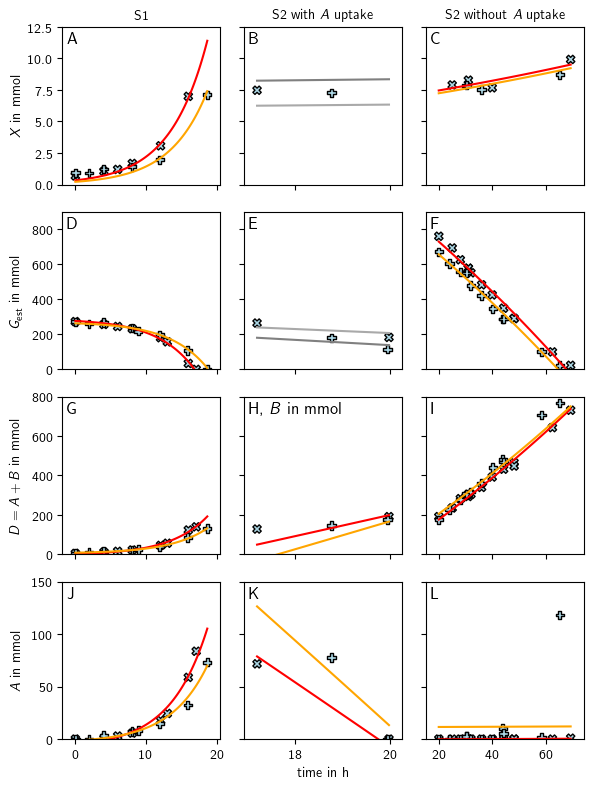

In [14]:
if 1:
    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath}\sansmath'
else:
    plt.rcParams["text.usetex"] = False
    
fig = plt.figure(dpi=100,figsize=(6,8))
axes = []
for i in range(12):
    axes.append(fig.add_subplot(4,3,i+1))

# STAGE 1
if True:
    sol_s1 = np.array([ 3.30688002e-01,  2.76727610e+02,  1.29034763e+00, -4.87213879e+00,
            2.14720685e-01,  2.63132928e+02,  7.99573785e+00, -1.51581386e+00,
            1.89444873e-01, -6.74732036e+00,  3.26340342e+00,  1.88328783e+00])

    loss, tmp_t, s_X1, s_X2, s_G1, s_G2, s_D1, s_D2, s_A1, s_A2 = fun_to_min_s1(sol_s1,True)

    axes[0].plot(tmp_t,s_X1,color="r")
    axes[0].plot(tmp_t,s_X2,color="orange")
    mscatter(st1.t,st1.X,axes[0],m=st1.color,edgecolor="k",color="lightblue")

    axes[3].plot(tmp_t,s_G1,color="r")
    axes[3].plot(tmp_t,s_G2,color="orange")
    mscatter(st1.t,st1.G,axes[3],m=st1.color,edgecolor="k",color="lightblue")

    axes[6].plot(tmp_t,s_D1,color="r")
    axes[6].plot(tmp_t,s_D2,color="orange")
    mscatter(st1.t,st1.D,axes[6],m=st1.color,edgecolor="k",color="lightblue")

    axes[9].plot(tmp_t,s_A1,color="r")
    axes[9].plot(tmp_t,s_A2,color="orange")
    mscatter(st1.t,st1.A,axes[9],m=st1.color,edgecolor="k",color="lightblue")

# STAGE 2b
if True:
    sol_s2b = np.array([ 6.76441118e+00,  9.87010363e+02, -1.47272600e+01, -3.08822180e-01,
            6.56353043e+00,  9.06658711e+02,  2.04377370e+01,  1.13976891e+01,
            4.91161851e-03, -1.81433576e+00,  1.34539308e+00,  1.25047577e-03])
    loss, tmp_t, s_X1, s_X2, s_G1, s_G2, s_D1, s_D2, s_A1, s_A2 = fun_to_min_s2b(sol_s2b,True)
    
    axes[2].plot(tmp_t,s_X1,color="r")
    axes[2].plot(tmp_t,s_X2,color="orange")
#    axes[2].scatter(st2b.t,st2b.X,color=st2b.color,edgecolor="k")
    mscatter(st2b.t,st2b.X,axes[2],m=st2b.color,edgecolor="k",color="lightblue")

    axes[5].plot(tmp_t,s_G1,color="r")
    axes[5].plot(tmp_t,s_G2,color="orange")
    #axes[5].scatter(st2b.t,st2b.G,color=st2b.color,edgecolor="k")
    mscatter(st2b.t,st2b.G,axes[5],m=st2b.color,edgecolor="k",color="lightblue")

    axes[8].plot(tmp_t,s_D1,color="r")
    axes[8].plot(tmp_t,s_D2,color="orange")
    #axes[8].scatter(st2b.t,st2b.D,color=st2b.color,edgecolor="k")
    mscatter(st2b.t,st2b.D,axes[8],m=st2b.color,edgecolor="k",color="lightblue")

    axes[11].plot(tmp_t,s_A1,color="r")
    axes[11].plot(tmp_t,s_A2,color="orange")
    #axes[11].scatter(st2b.t,st2b.A,color=st2b.color,edgecolor="k")
    mscatter(st2b.t,st2b.A,axes[11],m=st2b.color,edgecolor="k",color="lightblue")
    
# STAGE 2a
if True:
    sol_s2a = np.array([ 5.74599972e+00,  4.26568393e+02, -8.28757774e+02,  5.82160176e+02,
        7.56968280e+00,  4.26950894e+02, -1.18737880e+03,  7.89569345e+02,
        4.91100000e-03, -1.81430000e+00,  8.51662646e+00, -4.88519165e+00])
    loss, tmp_t, s_X1, s_X2, s_G1, s_G2, s_D1, s_D2, s_A1, s_A2 = fun_to_min_s2a(sol_s2a,True)
    
    axes[1].plot(tmp_t,s_X1,color="darkgray")
    axes[1].plot(tmp_t,s_X2,color="gray")
#    axes[1].scatter(st2a.t,st2a.X,color=st2a.color,edgecolor="k")
    mscatter(st2a.t,st2a.X,axes[1],m=st2a.color,edgecolor="k",color="lightblue")

    axes[4].plot(tmp_t,s_G1,color="darkgray")
    axes[4].plot(tmp_t,s_G2,color="gray")
 #   axes[4].scatter(st2a.t,st2a.G,color=st2a.color,edgecolor="k")
    mscatter(st2a.t,st2a.G,axes[4],m=st2a.color,edgecolor="k",color="lightblue")

    axes[7].plot(tmp_t,s_D1,color="r")
    axes[7].plot(tmp_t,s_D2,color="orange")
  #  axes[7].scatter(st2a.t,st2a.B,color=st2a.color,edgecolor="k")
    mscatter(st2a.t,st2a.D,axes[7],m=st2a.color,edgecolor="k",color="lightblue")

    axes[10].plot(tmp_t,s_A1,color="r")
    axes[10].plot(tmp_t,s_A2,color="orange")
   # axes[10].scatter(st2a.t,st2a.A,color=st2a.color,edgecolor="k")
    mscatter(st2a.t,st2a.A,axes[10],m=st2a.color,edgecolor="k",color="lightblue")

    
fs = 10
# axes[0].set_title("aerobic S1\n",fontsize=fs)
# axes[1].set_title("microaerobic S2\n"+r"with $A$ uptake",fontsize=fs)
# axes[2].set_title("microaerobic S2\n"+r"without $A$ uptake",fontsize=fs)
axes[0].set_title("S1",fontsize=fs)
axes[1].set_title("S2 with $A$ uptake",fontsize=fs)
axes[2].set_title("S2 without $A$ uptake",fontsize=fs)

axes[0].set_ylabel(r"$X$ in mmol",fontsize=fs)
axes[3].set_ylabel(r"$G_{\rm est}$ in mmol",fontsize=fs)
axes[6].set_ylabel(r"$D = A+B$ in mmol",fontsize=fs)
axes[9].set_ylabel(r"$A$ in mmol",fontsize=fs)

ws = .1
for ax in axes[0::3]:
    tt = st1.t.values
    mi = np.min(tt)
    ma = np.max(tt)
    de = ma-mi
    ax.set_xlim(mi-ws*de,ma+ws*de)
for ax in axes[1::3]:
    tt = st2a.t.values
    mi = np.min(tt)
    ma = np.max(tt)
    # print(np.mean([mi,ma]))
    de = ma-mi
    ax.set_xlim(mi-ws*de,ma+ws*de)
for ax in axes[2::3]:
    tt = st2b.t.values
    mi = np.min(tt)
    ma = np.max(tt)
    de = ma-mi
    ax.set_xlim(mi-ws*de,ma+ws*de)

for ax in axes[0:3]:
    ax.set_ylim(0,12.5)
for ax in axes[3:6]:
    ax.set_ylim(0,900)
for ax in axes[6:9]:
    ax.set_ylim(0,800)
for ax in axes[9:]:
    ax.set_ylim(0,150)
    
for ax in axes[0:9]:
    ax.set_xticklabels([])
for i in [1,2,4,5,7,8,10,11]:
    axes[i].set_yticklabels([])
    
axes[10].set_xlabel("time in h")

import matplotlib.transforms as mtransforms
for name, ax in zip(['A','B','C','D','E',"F","G",r"H, "+r"$B$ in mmol","I","J","K","L","M"],axes):
    trans = mtransforms.ScaledTranslation(5/100, -5/100, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, name, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top',
            bbox=dict(facecolor='none', edgecolor='none', pad=3.0))
    
    
fig.align_ylabels()
fig.align_xlabels()
plt.tight_layout()

plt.show()

## Production Envelope

In [15]:
GR_qX =  0.1894
GR_qG = -6.7473
GR_qD =  3.2634
GR_qA =  1.8833

print("Growth Stage")
print(f"GR_qX = {GR_qX:7.4f} 1/h")
print(f"GR_qG = {GR_qG:7.4f} mmol/(gX h)")
print(f"GR_qD = {GR_qD:7.4f} mmol/(gX h)")
print(f"GR_qA = {GR_qA:7.4f} mmol/(gX h)")

MA_qX =  0.0049
MA_qG = -1.8143
MA_qD =  1.3454
MA_qA = -4.8852
print("Microaerobic Stage")
print(f"MA_qX = {MA_qX:7.4f} 1/h")
print(f"MA_qG = {MA_qG:7.4f} mmol/(gX h)")
print(f"MA_qD = {MA_qD:7.4f} mmol/(gX h)")
print(f"MA_qA = {MA_qA:7.4f} mmol/(gX h)")

Growth Stage
GR_qX =  0.1894 1/h
GR_qG = -6.7473 mmol/(gX h)
GR_qD =  3.2634 mmol/(gX h)
GR_qA =  1.8833 mmol/(gX h)
Microaerobic Stage
MA_qX =  0.0049 1/h
MA_qG = -1.8143 mmol/(gX h)
MA_qD =  1.3454 mmol/(gX h)
MA_qA = -4.8852 mmol/(gX h)


### Check Feasibility of Extreme Points

In [16]:
print("MICROAEROBIC FBA")
with d4p3 as tmp:
    snek.set_bounds(tmp,"ATPM",6.86,1000)
    snek.set_bounds(tmp,"EX_glc__D_e",MA_qG,MA_qG)
    snek.set_bounds(tmp,"BIOMASS_Ecoli_core_w_GAM",MA_qX,MA_qX)
    snek.set_bounds(tmp,"acoin_synthesis",MA_qD,MA_qD)
    snek.set_bounds(tmp,"SK_acoin_c",MA_qA,1000)
    snek.set_objective(tmp,"EX_o2_e","max")
    sol = snek.sensitive_optimize(tmp,pFBA=True)
    fba_MA_qO = sol["EX_o2_e"]
    fba_MA_qA = sol["SK_acoin_c"]
    print(f"fba_MA_qO = {fba_MA_qO:.4f} mmol/(g h)")
    print(f"fba_MA_qA = {fba_MA_qA:.4f} mmol/(g h)")
    
print("GROWTH FBA")
with d4p3 as tmp:
    snek.set_bounds(tmp,"ATPM",6.86,1000)
    snek.set_bounds(tmp,"EX_glc__D_e",GR_qG,GR_qG)
    snek.set_bounds(tmp,"BIOMASS_Ecoli_core_w_GAM",GR_qX,GR_qX)
    snek.set_bounds(tmp,"acoin_synthesis",GR_qD,GR_qD)
    snek.set_bounds(tmp,"SK_acoin_c",GR_qA,1000)
    snek.set_objective(tmp,"EX_o2_e","max")
    sol = snek.sensitive_optimize(tmp,pFBA=True)
    fba_GR_qO = sol["EX_o2_e"]
    print(f"fba_GR_qO = {fba_GR_qO:.4f} mmol/(g h)")

MICROAEROBIC FBA
fba_MA_qO = -1.3536 mmol/(g h)
fba_MA_qA = -3.8366 mmol/(g h)
GROWTH FBA
fba_GR_qO = -4.5177 mmol/(g h)


### Construct Linear Funcitons

In [17]:
def line(x,k,d):
    return k*x + d

K_qG = (GR_qG-MA_qG)/(GR_qX-MA_qX)
D_qG = MA_qG - MA_qX*K_qG
print(f"qG = {K_qG:7.4f} qX + {D_qG:7.4f}")

K_qD = (GR_qD-MA_qD)/(GR_qX-MA_qX)
D_qD = MA_qD - MA_qX*K_qD
print(f"qD = {K_qD:7.4f} qX + {D_qD:7.4f}")

K_qA = (GR_qA-MA_qA)/(GR_qX-MA_qX)
D_qA = MA_qA - MA_qX*K_qA
print(f"qA = {K_qA:7.4f} qX + {D_qA:7.4f}")

qG = -26.7371 qX + -1.6833
qD = 10.3957 qX +  1.2945
qA = 36.6856 qX + -5.0650


### Print Production Envelope for KKT dFBA

In [18]:
print(f"NLc_q_G2[i=1:nFE],  q[glu,i] {-D_qG:+14.10f} {-K_qG:+14.10f} * q[xxx,i] == 0 # µ  -> qG")
print(f"NLc_q_A1[i=1:nFE],  q[aon,i] {-D_qA:+14.10f} {-K_qA:+14.10f} * q[xxx,i] == 0 # µ  -> qA")
print(f"NLc_q_D1[i=1:nFE],  q[dil,i] {-D_qD:+14.10f} {-K_qD:+14.10f} * q[xxx,i] == 0 # µ  -> qD")

NLc_q_G2[i=1:nFE],  q[glu,i]  +1.6832880759 +26.7371273713 * q[xxx,i] == 0 # µ  -> qG
NLc_q_A1[i=1:nFE],  q[aon,i]  +5.0649596206 -36.6856368564 * q[xxx,i] == 0 # µ  -> qA
NLc_q_D1[i=1:nFE],  q[dil,i]  -1.2944612466 -10.3956639566 * q[xxx,i] == 0 # µ  -> qD


In [19]:
qO_list = []
qX_list = []
qA_list = []
qB_list = []
for i in np.linspace(0,1,51):
    tmp_qX = i*MA_qX + (1-i)*GR_qX
    tmp_qG = i*MA_qG + (1-i)*GR_qG
    tmp_qD = i*MA_qD + (1-i)*GR_qD
    tmp_qA = i*fba_MA_qA + (1-i)*GR_qA
    
    with d4p3 as tmp:
        snek.set_bounds(tmp,"ATPM",6.86,1000)
        snek.set_bounds(tmp,"EX_glc__D_e",tmp_qG,tmp_qG)
        snek.set_bounds(tmp,"BIOMASS_Ecoli_core_w_GAM",tmp_qX,tmp_qX)
        snek.set_bounds(tmp,"acoin_synthesis",tmp_qD,tmp_qD)
        snek.set_bounds(tmp,"SK_acoin_c",tmp_qA,1000)
        snek.set_objective(tmp,"EX_o2_e","max")
        sol = snek.sensitive_optimize(tmp,pFBA=True)
        tmp_qO = sol["EX_o2_e"]
        tmp_qA = sol["SK_acoin_c"]
        qX_list.append(tmp_qX)
        qO_list.append(tmp_qO)
        qA_list.append(tmp_qA)

        # snek.set_bounds(tmp,"SK_acoin_c",tmp_qA,tmp_qA)
        # snek.set_bounds(tmp,"EX_o2_e",tmp_qO,tmp_qO)
        # snek.set_objective(tmp,"bt23dl_synthesis","max")
        # sol = snek.sensitive_optimize(tmp,pFBA=True)
        # tmp_qB = sol["bt23dl_synthesis"]
        # qB_list.append(tmp_qB)
    
    # print(f"tmp_qO = {tmp_qO:.4f} mmol/(g h)")
print("done")
qO_list = np.array(qO_list)
qX_list = np.array(qX_list)
qA_list = np.array(qA_list)
qB_list = np.array(qB_list)

done


# Figure 2

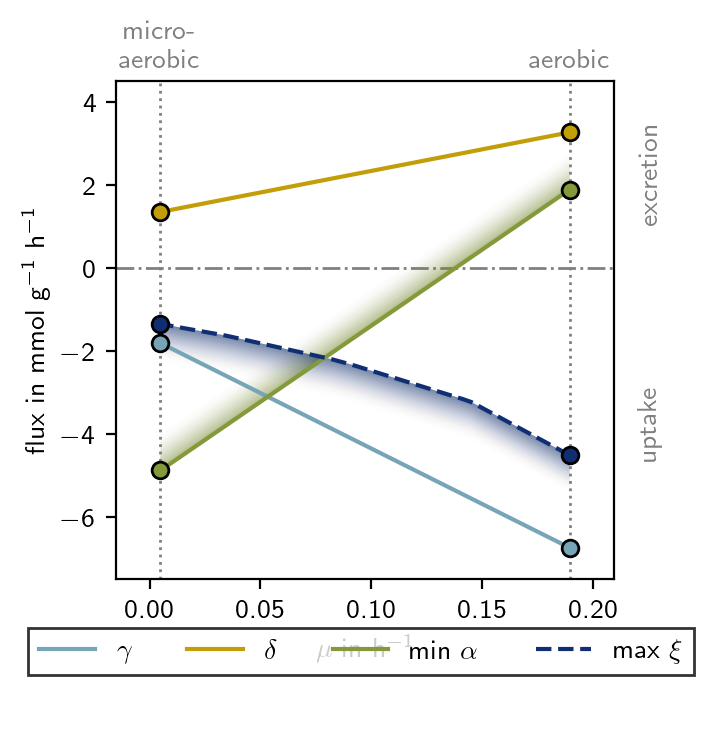

In [20]:
colors = ["#c39e08","#84993a","#57a585","#77a5b8","#1c6791","#102f73","#091c47"]

if 1:
    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['text.latex.preamble'] = r'\usepackage{sansmath}\sansmath'
else:
    plt.rcParams["text.usetex"] = False

fig = plt.figure(dpi=200,figsize=(3.5,5))
ax = plt.subplot(111,box_aspect=1)

plt.plot(qX_list,line(qX_list,K_qG,D_qG),label=r"$\gamma$",color=colors[3])
plt.plot(qX_list,line(qX_list,K_qD,D_qD), label=r"$\delta$",color=colors[0])
# plt.plot(qX_list,line(qX_list,K_qD,D_qD)-line(qX_list,K_qA,D_qA), label=r"max $\beta(\mu)$",color=colors[2])
plt.plot(qX_list,line(qX_list,K_qA,D_qA), label=r"min $\alpha$",color=colors[1])
plt.plot(qX_list,qO_list, label=r"max $\xi$",color=colors[5],linestyle="--")
# plt.plot(qX_list,qA_list, label=r"min $\alpha(\mu)$",color=colors[1],linestyle="--")
# plt.plot(qX_list,qB_list, label=r"max $\beta(\mu)$",color=colors[1],linestyle="--")


plt.scatter(qX_list[[0,-1]],qO_list[[0,-1]],edgecolor="k",zorder=10,color=colors[5])
plt.scatter(qX_list[[0,-1]],line(qX_list,K_qG,D_qG)[[0,-1]],edgecolor="k",zorder=10,color=colors[3])
plt.scatter(qX_list[[0,-1]],line(qX_list,K_qD,D_qD)[[0,-1]],edgecolor="k",zorder=10,color=colors[0])
plt.scatter(qX_list[[0,-1]],line(qX_list,K_qA,D_qA)[[0,-1]],edgecolor="k",zorder=10,color=colors[1])

plt.axvline(qX_list[0],color="grey",linestyle=":",linewidth=1)
plt.axvline(qX_list[-1],color="grey",linestyle=":",linewidth=1)
xo1 = 0 # -.022
xo2 = 0 #+.008
y = 4.7
plt.text(qX_list[-1]+xo1,y," micro-\naerobic",rotation=0,color="grey",va="bottom",ha="center")
plt.text(qX_list[0]+xo2,y,"aerobic",rotation=0,color="grey",va="bottom",ha="center")

plt.axhline(0,color="grey",linestyle="-.",linewidth=1,zorder=-5)

plt.xlabel(r"$\mu$ in h$^{-1}$")
plt.ylabel(r"flux in mmol g$^{-1}$ h$^{-1}$")

xo3 = .02
plt.xlim(qX_list[-1]-xo3,qX_list[0]+xo3)
ymin, ymax = -7.5, 4.5 #-7.5, +4.5
plt.ylim(ymin,ymax)
# plt.text(-.02,4.2,"uptake"+" "*10+"excretion",rotation=90,color="gray",va="top")
# plt.text(.22,4.2,"uptake"+"~"*20+"excretion ",rotation=90,color="gray",va="top")
plt.text(.22,ymax/2,"excretion ",rotation=90,color="gray",va="center")
plt.text(.22,ymin/2,"uptake",rotation=90,color="gray",va="center")

# SHADE MIN ALPHA
# Define the number of levels in the gradient and the maximum distance to fade
num_levels = 30
max_distance = 1  # This determines how far the gradient will fade

# Fill the area under the line with a gradient
x,y = qX_list,line(qX_list,K_qA,D_qA)
for i in range(num_levels):
    val = (np.exp(-i/num_levels)-0.4)*.1
    alpha = val
    # print(val)
    if alpha < 0:
        alpha = 0
    ax.fill_between(x, y, y + (i + 1) * max_distance / num_levels,
                    color=colors[1], alpha=alpha, edgecolor='none')

x,y = qX_list,qO_list
for i in range(num_levels):
    val = (np.exp(-i/num_levels)-0.4)*.1
    alpha = val
    # print(val)
    if alpha < 0:
        alpha = 0
    ax.fill_between(x, y, y - (i + 1) * max_distance / num_levels,
                    color=colors[5], alpha=alpha, edgecolor='none')




fig.tight_layout()
fig.legend(loc=(.04,.1),ncols=4)

fig.tight_layout()
plt.show()